In [1]:
import os
import pandas as pd
import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import CuDNNGRU
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Lambda
from keras.layers import Dropout
from keras.layers import SimpleRNN
from keras.utils import generic_utils
from keras.utils import Sequence
from keras import regularizers
from keras import optimizers
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
import scipy 
import math
import h5py
import time
import copy
import sys
import feather
from sklearn.metrics import mean_absolute_error
from numpy.random import seed
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)
np.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


In [2]:
import keras
print(os.getcwd())
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

/home/whsu014/dev/mlrig/Experiments


In [3]:
view_1hot_df = feather.read_dataframe("/home/whsu014/data/view_1hot_nona_len29_float_age_impute_and_True_HG_100096inds.feather")
#view_1hot_test_wout_true_df = feather.read_dataframe("/home/whsu014/data/view_1hot_test_unflattened_wout_true_HG_imputed.feather")

#view_1hot_wout_true_df = feather.read_dataframe("/home/whsu014/data/train_24to4.feather")
#view_1hot_test_wout_true_df = feather.read_dataframe("/home/whsu014/data/test_24to4.feather")
print(view_1hot_df.columns)
print(view_1hot_df.shape)

print(view_1hot_df['CVD_ISOSORBRIDE_DINITRATE'].unique())
view_1hot_df = view_1hot_df.drop(['CVD_ISOSORBRIDE_DINITRATE'], axis=1)
print(view_1hot_df.shape)
#print(view_1hot_test_wout_true_df.shape)
#print(view_1hot_df.iloc[:, 0].equals(view_1hot_test_wout_true_df.iloc[:, 0]))
#feather.write_dataframe(view_1hot_df, "/home/whsu014/data/true_27to1.feather")

Index(['VSIMPLE_INDEX_MASTER', 'QUARTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1',
       'ETHN_2', 'ETHN_3', 'ETHN_4', 'ETHN_5',
       ...
       'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION', 'PT_IMP_FATAL_CVD',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL',
       'TRUE_HBA1C', 'TRUE_EGFR'],
      dtype='object', length=191)
(2902784, 191)
[0.]
(2902784, 190)


In [4]:
view_1hot_df.describe()

,VSIMPLE_INDEX_MASTER,QUARTER,AGE,SEX,NZDEP,ETHN_1,ETHN_2,ETHN_3,ETHN_4,ETHN_5,TEST,HDL,LDL,TRI,TCL,TCHDL,TESTED,DIED,LL_SIMVASTATIN,LL_BEZAFIBRATE,LL_ATORVASTATIN,LL_EZETIMIBE,LL_NICOTINIC_ACID,LL_ACIPIMOX,LL_CHOLESTYRAMINE,LL_COLESTIPOL_HYDROCHLORIDE,LL_PRAVASTATIN,LL_EZETIMIBE_WITH_SIMVASTATIN,LL_GEMFIBROZIL,LL_PDC,CVD_FELODIPINE,CVD_QUINAPRIL,CVD_METOPROLOL_SUCCINATE,CVD_CILAZAPRIL,CVD_ATENOLOL,CVD_BENDROFLUMETHIAZIDE,CVD_WARFARIN_SODIUM,CVD_FUROSEMIDE,CVD_CELIPROLOL,CVD_DILTIAZEM_HYDROCHLORIDE,CVD_ASPIRIN,CVD_NIFEDIPINE,CVD_CAPTOPRIL,CVD_DIPYRIDAMOLE,CVD_CANDESARTAN_CILEXETIL,CVD_INDAPAMIDE,CVD_ENALAPRIL_MALEATE,CVD_SOTALOL,CVD_GLYCERYL_TRINITRATE,CVD_ISOSORBIDE_MONONITRATE,CVD_PINDOLOL,CVD_CARVEDILOL,CVD_METHYLDOPA,CVD_LOSARTAN_POTASSIUM,CVD_VERAPAMIL_HYDROCHLORIDE,CVD_AMILORIDE_HYDROCHLORIDE,CVD_CLONIDINE_HYDROCHLORIDE,CVD_CLONIDINE,CVD_NADOLOL,CVD_PROPRANOLOL,CVD_AMLODIPINE,CVD_LABETALOL,CVD_LISINOPRIL,CVD_TRIAMTERENE,CVD_TIMOLOL,CVD_METOPROLOL_TARTRATE,CVD_ACEBUTOLOL,CVD_PERHEXILINE_MALEATE,CVD_CHLORTALIDONE,CVD_BUMETANIDE,CVD_PERINDOPRIL,CVD_TRANDOLAPRIL,CVD_CLOPIDOGREL,CVD_ISRADIPINE,CVD_RIVAROXABAN,CVD_DABIGATRAN,CVD_BISOPROLOL_FUMARATE,CVD_PRASUGREL,CVD_NICORANDIL,CVD_METOLAZONE,CVD_TICAGRELOR,CVD_HYDRALAZINE_HYDROCHLORIDE,CVD_HYDROCHLOROTHIAZIDE,OTHER_TENOXICAM,OTHER_PANTOPRAZOLE,OTHER_OMEPRAZOLE,OTHER_NAPROXEN_SODIUM,OTHER_DICLOFENAC_SODIUM,OTHER_METFORMIN_HYDROCHLORIDE,OTHER_SULINDAC,OTHER_GLICLAZIDE,OTHER_GLIPIZIDE,OTHER_INSULIN_ISOPHANE,OTHER_INSULIN_NEUTRAL,OTHER_KETOPROFEN,OTHER_IBUPROFEN,OTHER_INSULIN_ASPART,OTHER_PREDNISONE,OTHER_INDOMETHACIN,OTHER_NAPROXEN,OTHER_GLIBENCLAMIDE,OTHER_RANITIDINE,OTHER_PIROXICAM,OTHER_INSULIN_LISPRO,OTHER_TIAPROFENIC_ACID,OTHER_PIOGLITAZONE,OTHER_DEXAMETHASONE,OTHER_INSULIN_ZINC_SUSPENSION,OTHER_HYDROCORTISONE,OTHER_PREDNISOLONE,OTHER_TOLBUTAMIDE,OTHER_MEFENAMIC_ACID,OTHER_LANSOPRAZOLE,OTHER_METHYLPREDNISOLONE,OTHER_INSULIN_GLARGINE,OTHER_INSULIND_GLULISINE,OTHER_AMOXYCILLIN,OTHER_CLARITHROMYCIN,OTHER_INSULIN_LISPRO_PROTAMINE,OTHER_INSULIN_ASPART_PROTAMINE,OTHER_VILDAGLIPTIN,NUMBER_OF_DAYS,ACUTE_ADM,hx_broad_cvd,hx_athero_cvd,hx_chd_diags,hx_acs,hx_mi,hx_unst_angina,hx_angina,hx_other_chd,hx_chd_procs,hx_pci,hx_cabg,hx_other_chd_procs,hx_pvd_diags,hx_pvd_procs,hx_haemorrhagic_stroke,hx_cevd,hx_ischaemic_stroke,hx_tia,hx_other_cevd,hx_heart_failure,hx_atrial_fibrillation,mortality_broad_cvd_with_other,mortality_other_related_cvd_deaths,out_broad_cvd,out_athero_cvd,out_chd,out_mi,out_acs,out_unst_angina,out_angina,out_other_chd,out_pvd_diags,out_pvd_procs,out_pci_cabg,out_haemorrhagic_stroke,out_cevd,out_ischaemic_stroke,out_tia,out_other_cevd,out_heart_failure,out_atrial_fibrillation,HBA1C,TEST_HBA1C,TESTED_HBA1C,EGFR,TEST_EGFR,TESTED_EGFR,PT_SBP,PT_SBP2,PT_DBP,PT_DBP2,PT_SMOKING,PT_EN_TCHDL,PT_DIABETES,PT_FAMILY_HISTORY,PT_GEN_LIPID,PT_RENAL,PT_DIABETES_YR,PT_ATRIAL_FIBRILLATION,PT_IMP_FATAL_CVD
count,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.

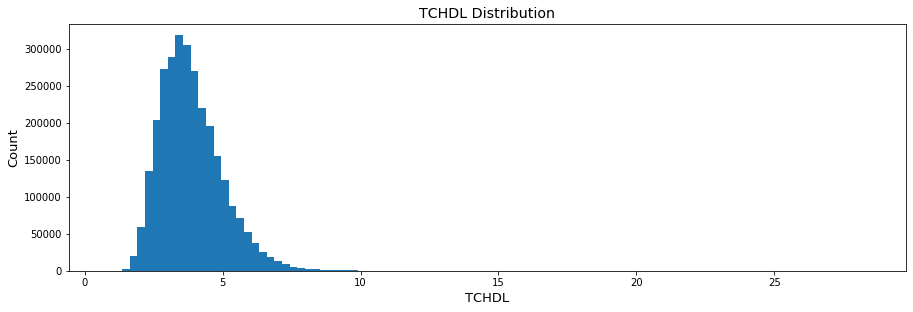

Max: 28.4
Min: 0.8


In [5]:
pyplot.figure(figsize=(15,10))
pyplot.subplot(211)
fs = 13
pyplot.title('TCHDL Distribution', fontsize=fs*1.1)
pyplot.xlabel('TCHDL', fontsize=fs)
pyplot.ylabel('Count', fontsize=fs)
pyplot.hist(view_1hot_df.TCHDL, bins=100)
#filename = "/home/whsu014/plots/TCHDL_Distribution.png"
#pyplot.savefig(filename)
pyplot.show()

print("Max:", max(view_1hot_df.TCHDL))
print("Min:", min(view_1hot_df.TCHDL))

In [6]:
print("Number of inds:", len(view_1hot_df['VSIMPLE_INDEX_MASTER'].unique()))
# set to length 28
print(view_1hot_df.shape[0]/29)
view_1hot_df = copy.deepcopy(view_1hot_df[view_1hot_df['QUARTER']!=0])
print(view_1hot_df.shape[0]/28)
# Take 90000 inds for train and validation set
# remove true values
# remove QUARTER
view_1hot_df = view_1hot_df.drop(['QUARTER'], axis=1)
train_v = copy.deepcopy(view_1hot_df.iloc[:(28*90000), :-7].values)
print(train_v.shape)
print(train_v.shape[0]/28)

Number of inds: 100096
100096.0
100096.0
(2520000, 182)
90000.0


In [7]:
# standardise data
# z = (X - u)/s
# u is the mean of the training samples
# s is the standard devidation of the training samples
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_v) 

In [8]:
print(scaled_train.shape)
print(view_1hot_df.columns.get_loc('TCHDL'))
print(list(view_1hot_df.columns))

(2520000, 182)
14
['VSIMPLE_INDEX_MASTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1', 'ETHN_2', 'ETHN_3', 'ETHN_4', 'ETHN_5', 'TEST', 'HDL', 'LDL', 'TRI', 'TCL', 'TCHDL', 'TESTED', 'DIED', 'LL_SIMVASTATIN', 'LL_BEZAFIBRATE', 'LL_ATORVASTATIN', 'LL_EZETIMIBE', 'LL_NICOTINIC_ACID', 'LL_ACIPIMOX', 'LL_CHOLESTYRAMINE', 'LL_COLESTIPOL_HYDROCHLORIDE', 'LL_PRAVASTATIN', 'LL_EZETIMIBE_WITH_SIMVASTATIN', 'LL_GEMFIBROZIL', 'LL_PDC', 'CVD_FELODIPINE', 'CVD_QUINAPRIL', 'CVD_METOPROLOL_SUCCINATE', 'CVD_CILAZAPRIL', 'CVD_ATENOLOL', 'CVD_BENDROFLUMETHIAZIDE', 'CVD_WARFARIN_SODIUM', 'CVD_FUROSEMIDE', 'CVD_CELIPROLOL', 'CVD_DILTIAZEM_HYDROCHLORIDE', 'CVD_ASPIRIN', 'CVD_NIFEDIPINE', 'CVD_CAPTOPRIL', 'CVD_DIPYRIDAMOLE', 'CVD_CANDESARTAN_CILEXETIL', 'CVD_INDAPAMIDE', 'CVD_ENALAPRIL_MALEATE', 'CVD_SOTALOL', 'CVD_GLYCERYL_TRINITRATE', 'CVD_ISOSORBIDE_MONONITRATE', 'CVD_PINDOLOL', 'CVD_CARVEDILOL', 'CVD_METHYLDOPA', 'CVD_LOSARTAN_POTASSIUM', 'CVD_VERAPAMIL_HYDROCHLORIDE', 'CVD_AMILORIDE_HYDROCHLORIDE', 'CVD_CLONIDINE_

In [9]:
###################################
# CuDNNLSTM and SimpleRNN
###################################

print(scaled_train.base is view_1hot_df)
print(scaled_train.shape)

num_of_inds = scaled_train.shape[0]//28
print("Number of individuals: ", num_of_inds)

x_train_list = []
y_train_list = []

start_time = time.time()
for i in range(num_of_inds): #num_of_inds[]
    ind_train = copy.deepcopy(scaled_train[(i*28):((i+1)*28), :])
    ind_train_x = copy.deepcopy(ind_train[0:8, :]) #8
    #z_pad = np.zeros((12, 184)) #changed from 12 to 20 timesteps
    ##############################
    #instead zero padding
    #extrapolate
    #z_pad = np.array([ind_train[7, :]]*12)
    #z_pad = np.array([ind_train[0, :]]*12)
    ##############################
    #ind_train_x = np.append(ind_train_x, z_pad, axis=0)
    x_train_list.append(ind_train_x)
    ##################################################
    # Training just on TCHDL
    ##################################################
    y_train_list.append(np.array([ind_train[8:, 14]]).T) #8:
    #if i % 1000 == 0:
    #    print("Iteration: ", str(i))
    #    print(time.time() - start_time)
print("Time to build train test data: ", time.time() - start_time)
x_train = np.array(x_train_list)
y_train = np.array(y_train_list)

print(x_train.shape)
print(y_train.shape)

False
(2520000, 182)
Number of individuals:  90000
Time to build train test data:  1.4755401611328125
(90000, 8, 182)
(90000, 20, 1)


In [10]:
num_per_fold = x_train.shape[0]//10
print(num_per_fold)

9000


In [17]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

num_per_fold = x_train.shape[0]//10
print(num_per_fold)

units_list = [2, 4, 8, 16, 32]
batch_size_list = [64, 128, 256, 512, 1024]

start_time = time.time()

exp_record = []

for units in units_list:
    for batch_s in batch_size_list:
        for f in range(5):#10
            #start = f*num_per_fold
            end = (f+1)*num_per_fold
            train1_x = x_train[:end, ]
            train2_x = x_train[end:, ]
            train_x_lstm = np.append(train2_x, train1_x, axis=0) 
            train1_y = y_train[:end, ]
            train2_y = y_train[end:, ]
            train_y_lstm = np.append(train2_y, train1_y, axis=0)

            start_time_inner = time.time()
            #config = tf.ConfigProto(log_device_placement = True)
            #config.gpu_options.visible_device_list='1'
            with tf.Session(config = tf.ConfigProto(log_device_placement = True)):
                model = Sequential()
                model.add(CuDNNLSTM(units, #CuDNNLSTM
                                    kernel_regularizer=regularizers.l2(0.01),
                                    #dropout=0.5, #recurrent_dropout=0.5,
                                    #recurrent_regularizer=regularizers.l2(0.01),
                                    #bias_regularizer=regularizers.l2(0.01),
                                    #activity_regularizer=regularizers.l2(0.01),
                                    #return_sequences=True, 
                                    input_shape=(8, 182))) #20 , 27
                model.add(RepeatVector(20))
                model.add(CuDNNLSTM(units, 
                                    kernel_regularizer=regularizers.l2(0.01),
                                    return_sequences=True))
                model.add(TimeDistributed(Dense(1)))
                #adam = optimizers.Adam(lr=0.0015) #decay=1e-4
                #sgdm = optimizers.SGD(lr=0.001, momentum=0.9, decay=1e-7) 
                model.compile(loss='mae', optimizer='adam')#'adam'
                val_weight = "val_weights" + str(f+1) + ".hdf5"
                val_checkpointer = ModelCheckpoint(filepath=val_weight,
                                            monitor='val_loss', verbose=1,
                                            save_best_only=True)
                history = model.fit(train_x_lstm, train_y_lstm, batch_size=batch_s, 
                                    epochs=100, validation_split=0.1, 
                                    callbacks=[val_checkpointer], 
                                    verbose=2, 
                                    shuffle=False) 
                print("#################################")
                print("Number of units:", units)
                print("Batch size:", batch_s)
                print("Fold:", f)
                print("best val loss:", min(history.history['val_loss']))
                exp_record.append([units, batch_s, f, min(history.history['val_loss'])])
                print("#################################")
                if(f==4):
                    print(exp_record)
                pyplot.plot(history.history['loss'], label='train')
                pyplot.plot(history.history['val_loss'], label='validation')
                pyplot.legend()
                pyplot.show()
    end_time = time.time()
    print("Time to train LSTM: ", time.time() - start_time_inner)
print("Entire process took: ", time.time() - start_time)

print("Experiment record:")
print(exp_record)

Experiment record:
[[2, 64, 0, 0.44755742934015064], [2, 64, 1, 0.4477371150917477], [2, 64, 2, 0.453066474782096], [2, 64, 3, 0.44462686043315464], [2, 64, 4, 0.45077708869510225], [2, 128, 0, 0.44713114319907293], [2, 128, 1, 0.4438802139494154], [2, 128, 2, 0.4509398983054691], [2, 128, 3, 0.4415803746647305], [2, 128, 4, 0.45020293479495577], [2, 256, 0, 0.4463628982173072], [2, 256, 1, 0.44196581387519834], [2, 256, 2, 0.4493114028506809], [2, 256, 3, 0.4401700519720713], [2, 256, 4, 0.4476276434792413], [2, 512, 0, 0.44397732861836753], [2, 512, 1, 0.44452238829930624], [2, 512, 2, 0.44796921441290116], [2, 512, 3, 0.44206448313925], [2, 512, 4, 0.4468552339871724], [2, 1024, 0, 0.44405503996213275], [2, 1024, 1, 0.4415261368221707], [2, 1024, 2, 0.4521231859789954], [2, 1024, 3, 0.4427647542423672], [2, 1024, 4, 0.44754041038619147], [4, 64, 0, 0.44592894649505616], [4, 64, 1, 0.44562794544961715], [4, 64, 2, 0.45155358282725017], [4, 64, 3, 0.4427976631588406], [4, 64, 4, 0.449

In [3]:
exp_record = [[2, 64, 0, 0.44755742934015064], [2, 64, 1, 0.4477371150917477], [2, 64, 2, 0.453066474782096], [2, 64, 3, 0.44462686043315464], [2, 64, 4, 0.45077708869510225], [2, 128, 0, 0.44713114319907293], [2, 128, 1, 0.4438802139494154], [2, 128, 2, 0.4509398983054691], [2, 128, 3, 0.4415803746647305], [2, 128, 4, 0.45020293479495577], [2, 256, 0, 0.4463628982173072], [2, 256, 1, 0.44196581387519834], [2, 256, 2, 0.4493114028506809], [2, 256, 3, 0.4401700519720713], [2, 256, 4, 0.4476276434792413], [2, 512, 0, 0.44397732861836753], [2, 512, 1, 0.44452238829930624], [2, 512, 2, 0.44796921441290116], [2, 512, 3, 0.44206448313925], [2, 512, 4, 0.4468552339871724], [2, 1024, 0, 0.44405503996213275], [2, 1024, 1, 0.4415261368221707], [2, 1024, 2, 0.4521231859789954], [2, 1024, 3, 0.4427647542423672], [2, 1024, 4, 0.44754041038619147], [4, 64, 0, 0.44592894649505616], [4, 64, 1, 0.44562794544961715], [4, 64, 2, 0.45155358282725017], [4, 64, 3, 0.4427976631588406], [4, 64, 4, 0.44912781222661335], [4, 128, 0, 0.44324777960777284], [4, 128, 1, 0.4419995652569665], [4, 128, 2, 0.44893405225541855], [4, 128, 3, 0.4392013733651903], [4, 128, 4, 0.44932811742358736], [4, 256, 0, 0.4422315348519219], [4, 256, 1, 0.44163418605592514], [4, 256, 2, 0.44816050407621594], [4, 256, 3, 0.4379821915626526], [4, 256, 4, 0.44481919935014513], [4, 512, 0, 0.4422868671417236], [4, 512, 1, 0.44093207528856065], [4, 512, 2, 0.4467997477319505], [4, 512, 3, 0.43829669194751314], [4, 512, 4, 0.4449486061731974], [4, 1024, 0, 0.4411603412893083], [4, 1024, 1, 0.44299099622832405], [4, 1024, 2, 0.4470482470459408], [4, 1024, 3, 0.43926511194970874], [4, 1024, 4, 0.44620514543851214], [8, 64, 0, 0.4457553519407908], [8, 64, 1, 0.44610114110840693], [8, 64, 2, 0.451776104927063], [8, 64, 3, 0.44278562270270455], [8, 64, 4, 0.4481624654663934], [8, 128, 0, 0.44379352712631226], [8, 128, 1, 0.4431342912779914], [8, 128, 2, 0.44922088249524433], [8, 128, 3, 0.4397558829784393], [8, 128, 4, 0.44580192226833765], [8, 256, 0, 0.439261093960868], [8, 256, 1, 0.4418525846534305], [8, 256, 2, 0.4473290330833859], [8, 256, 3, 0.43756268538369075], [8, 256, 4, 0.4438902778625488], [8, 512, 0, 0.44025984393225776], [8, 512, 1, 0.4399904157055749], [8, 512, 2, 0.44482472806506684], [8, 512, 3, 0.4366878453095754], [8, 512, 4, 0.44388545523749456], [8, 1024, 0, 0.43944840301407706], [8, 1024, 1, 0.44017817889319527], [8, 1024, 2, 0.44585042606459724], [8, 1024, 3, 0.4383927130169339], [8, 1024, 4, 0.44483727200826007], [16, 64, 0, 0.44806686533821954], [16, 64, 1, 0.4479850736724006], [16, 64, 2, 0.4520773473580678], [16, 64, 3, 0.44432297298643325], [16, 64, 4, 0.44963588847054375], [16, 128, 0, 0.44081996183925204], [16, 128, 1, 0.4427830457687378], [16, 128, 2, 0.4495636248058743], [16, 128, 3, 0.4400199228392707], [16, 128, 4, 0.4443427196608649], [16, 256, 0, 0.43904231691360474], [16, 256, 1, 0.4390756479634179], [16, 256, 2, 0.4475190722677443], [16, 256, 3, 0.4366845322714912], [16, 256, 4, 0.4438809428744846], [16, 512, 0, 0.43892980482843186], [16, 512, 1, 0.4396729721493191], [16, 512, 2, 0.4444692705207401], [16, 512, 3, 0.4392768981721666], [16, 512, 4, 0.44327808048990036], [16, 1024, 0, 0.4399282226032681], [16, 1024, 1, 0.4415465936660767], [16, 1024, 2, 0.4482347783777449], [16, 1024, 3, 0.4399686884880066], [16, 1024, 4, 0.44469002781973943], [32, 64, 0, 0.45133720111846926], [32, 64, 1, 0.4503709304862552], [32, 64, 2, 0.45572317833370635], [32, 64, 3, 0.4476134623951382], [32, 64, 4, 0.4532708160612318], [32, 128, 0, 0.44400791165563797], [32, 128, 1, 0.4456929563946194], [32, 128, 2, 0.45221454683939616], [32, 128, 3, 0.4432037423451742], [32, 128, 4, 0.4489763761096531], [32, 256, 0, 0.4405864128006829], [32, 256, 1, 0.4415403435230255], [32, 256, 2, 0.4476494742499457], [32, 256, 3, 0.4393243713113997], [32, 256, 4, 0.44709120231204563], [32, 512, 0, 0.4408791944980621], [32, 512, 1, 0.441487286541197], [32, 512, 2, 0.4460095887184143], [32, 512, 3, 0.4384260777367486], [32, 512, 4, 0.443275639322069], [32, 1024, 0, 0.4420065325366126], [32, 1024, 1, 0.4413031300968594], [32, 1024, 2, 0.4491159916453891], [32, 1024, 3, 0.44091179757648047], [32, 1024, 4, 0.4451499152448442]]

complete_v = np.array(exp_record)
print(complete_v.shape)
#print(exp_record)

val_loss_list = []
for i in range(25):
    model_v = complete_v[(i*5):((i+1)*5), :]
    print("#######################")
    print("Units:\t\t", model_v[0, 0])
    print("Batch size:\t", model_v[0, 1])
    #print("Val loss (mean):", np.mean(model_v[:, 3]))
    #print("Val loss (Std): ", np.std(model_v[:, 3]))
    print("Val loss (mean):", np.round(np.mean(model_v[:, 3]), decimals=5))
    print("Val loss (Std): ", np.round(np.std(model_v[:, 3]), decimals=5))
    print("#######################")
    val_loss_list.append(np.mean(model_v[:, 3]))
print(min(val_loss_list))

(125, 4)
#######################
Units:		 2.0
Batch size:	 64.0
Val loss (mean): 0.44875
Val loss (Std):  0.0029
#######################
#######################
Units:		 2.0
Batch size:	 128.0
Val loss (mean): 0.44675
Val loss (Std):  0.00359
#######################
#######################
Units:		 2.0
Batch size:	 256.0
Val loss (mean): 0.44509
Val loss (Std):  0.00346
#######################
#######################
Units:		 2.0
Batch size:	 512.0
Val loss (mean): 0.44508
Val loss (Std):  0.0021
#######################
#######################
Units:		 2.0
Batch size:	 1024.0
Val loss (mean): 0.4456
Val loss (Std):  0.00383
#######################
#######################
Units:		 4.0
Batch size:	 64.0
Val loss (mean): 0.44701
Val loss (Std):  0.00303
#######################
#######################
Units:		 4.0
Batch size:	 128.0
Val loss (mean): 0.44454
Val loss (Std):  0.00397
#######################
#######################
Units:		 4.0
Batch size:	 256.0
Val loss (mean): 0.44297
Val 

In [12]:
###################################
# get model summary
###################################
units = 16
batch_size = 64
model = Sequential()
model.add(CuDNNLSTM(units, 
         input_shape=(8, 182))) 
model.add(RepeatVector(20))
model.add(CuDNNLSTM(units, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 16)                12800     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 20, 16)            0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 20, 16)            2176      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 1)             17        
Total params: 14,993
Trainable params: 14,993
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
###########################
# generate random numbers
# for layer 1 and 2 
# L2 search
###########################
from numpy.random import seed
seed(5) # seed 1 for LSTM seed 5 for SimpleRNN
# L2 for layer 1 between 0.005 and 0.015
L2_1_list = []
for i in range(25):
    L2_1_list.append(np.random.uniform(0.005, 0.015))
# L2 for layer 2 between 1e-4 and 1e-8
L2_2_list = []
for i in range(25):
    r = -4*np.random.rand()
    s = 0.0001*(10**r)
    L2_2_list.append(s)
print(min(L2_1_list))
print(max(L2_1_list))
print(min(L2_2_list))
print(max(L2_2_list))
print(L2_1_list)
print(L2_2_list)

0.005807412687648748
0.014186109079379214
1.1415695836643046e-08
9.849888381867553e-05
[0.0072199317108973945, 0.013707323061773764, 0.007067191553394264, 0.014186109079379214, 0.00988411188794829, 0.011117438629026456, 0.012659078564803155, 0.010184179878729431, 0.007968005015762218, 0.006877212286612516, 0.005807412687648748, 0.012384402961989699, 0.00941309222895953, 0.006583098677126512, 0.013799370312012789, 0.0077408646199222456, 0.009142350190810514, 0.007960799327336478, 0.011287879088794833, 0.01079837810189545, 0.010999291966249875, 0.007658191175355072, 0.007846858806413637, 0.007535882057737874, 0.00827563947688734]
[2.6505914783975005e-05, 2.175447240794305e-05, 1.394048500868052e-08, 1.4424246609572321e-08, 1.76336159394718e-05, 7.994176883795366e-05, 1.5197698149525386e-05, 1.5871776653550959e-07, 7.619766407841797e-08, 8.095946512357794e-05, 4.890447122292986e-07, 9.849888381867553e-05, 8.671805976616734e-07, 2.7594294531006584e-07, 1.1415695836643046e-08, 9.19622554919

In [20]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

num_per_fold = x_train.shape[0]//10
print(num_per_fold)

units = 16
batch_s = 2048

start_time = time.time()

exp_record = []

for i in range(25):
    L2_1 = L2_1_list[i]
    L2_2 = L2_2_list[i]
    for f in range(5):#10
        #start = f*num_per_fold
        end = (f+1)*num_per_fold
        train1_x = x_train[:end, ]
        train2_x = x_train[end:, ]
        train_x_lstm = np.append(train2_x, train1_x, axis=0) #new obj
        train1_y = y_train[:end, ]
        train2_y = y_train[end:, ]
        train_y_lstm = np.append(train2_y, train1_y, axis=0)

        start_time_inner = time.time()
        #config = tf.ConfigProto(log_device_placement = True)
        #config.gpu_options.visible_device_list='1'
        with tf.Session(config = tf.ConfigProto(log_device_placement = True)):
            model = Sequential()
            model.add(SimpleRNN(units, #CuDNNLSTM
                                kernel_regularizer=regularizers.l2(L2_1),
                                input_shape=(8, 182))) #20 , 27
            model.add(RepeatVector(20))
            model.add(SimpleRNN(units, 
                                kernel_regularizer=regularizers.l2(L2_2),
                                return_sequences=True))
            model.add(TimeDistributed(Dense(1)))
            #adam = optimizers.Adam(lr=0.0015) #decay=1e-4
            #sgdm = optimizers.SGD(lr=0.001, momentum=0.9, decay=1e-7) 
            model.compile(loss='mae', optimizer='adam')#'adam'
            train_weight = "train_weights" + str(f+1) + ".hdf5"
            val_weight = "val_weights" + str(f+1) + ".hdf5"
            val_checkpointer = ModelCheckpoint(filepath=val_weight,
                                               monitor='val_loss', verbose=1,
                                               save_best_only=True)
            history = model.fit(train_x_lstm, train_y_lstm, batch_size=batch_s, 
                                epochs=100, validation_split=0.1, 
                                callbacks=[val_checkpointer], 
                                verbose=2, 
                                shuffle=False) 
            print("#################################")
            print("Number of units:", units)
            print("Batch size:", batch_s)
            print("L2 Layer 1:", L2_1)
            print("L2 layer 2:", L2_2)
            print("Fold:", f)
            print("best val loss:", min(history.history['val_loss']))
            exp_record.append([units, batch_s, L2_1, L2_2, 
                               f, min(history.history['val_loss'])])
            print("#################################")
            if(f==4):
                print(exp_record)
            pyplot.plot(history.history['loss'], label='train')
            pyplot.plot(history.history['val_loss'], label='validation')
            pyplot.legend()
            pyplot.show()
        print("Time to train LSTM: ", time.time() - start_time_inner)
print("Entire process took: ", time.time() - start_time)

print("Experiment record:")
print(exp_record)

Experiment record:
[[16, 2048, 0.0072199317108973945, 2.6505914783975005e-05, 0, 0.43987639170222814], [16, 2048, 0.0072199317108973945, 2.6505914783975005e-05, 1, 0.4372662083837721], [16, 2048, 0.0072199317108973945, 2.6505914783975005e-05, 2, 0.44567474529478285], [16, 2048, 0.0072199317108973945, 2.6505914783975005e-05, 3, 0.4382176331943936], [16, 2048, 0.0072199317108973945, 2.6505914783975005e-05, 4, 0.4437246675491333], [16, 2048, 0.013707323061773764, 2.175447240794305e-05, 0, 0.43825197784105935], [16, 2048, 0.013707323061773764, 2.175447240794305e-05, 1, 0.4412613475587633], [16, 2048, 0.013707323061773764, 2.175447240794305e-05, 2, 0.4445653887589773], [16, 2048, 0.013707323061773764, 2.175447240794305e-05, 3, 0.43705326456493804], [16, 2048, 0.013707323061773764, 2.175447240794305e-05, 4, 0.44568431764178806], [16, 2048, 0.007067191553394264, 1.394048500868052e-08, 0, 0.4370287908713023], [16, 2048, 0.007067191553394264, 1.394048500868052e-08, 1, 0.4356034419271681], [16, 

In [6]:
exp_record = [[16, 2048, 0.0072199317108973945, 2.6505914783975005e-05, 0, 0.43987639170222814], [16, 2048, 0.0072199317108973945, 2.6505914783975005e-05, 1, 0.4372662083837721], [16, 2048, 0.0072199317108973945, 2.6505914783975005e-05, 2, 0.44567474529478285], [16, 2048, 0.0072199317108973945, 2.6505914783975005e-05, 3, 0.4382176331943936], [16, 2048, 0.0072199317108973945, 2.6505914783975005e-05, 4, 0.4437246675491333], [16, 2048, 0.013707323061773764, 2.175447240794305e-05, 0, 0.43825197784105935], [16, 2048, 0.013707323061773764, 2.175447240794305e-05, 1, 0.4412613475587633], [16, 2048, 0.013707323061773764, 2.175447240794305e-05, 2, 0.4445653887589773], [16, 2048, 0.013707323061773764, 2.175447240794305e-05, 3, 0.43705326456493804], [16, 2048, 0.013707323061773764, 2.175447240794305e-05, 4, 0.44568431764178806], [16, 2048, 0.007067191553394264, 1.394048500868052e-08, 0, 0.4370287908713023], [16, 2048, 0.007067191553394264, 1.394048500868052e-08, 1, 0.4356034419271681], [16, 2048, 0.007067191553394264, 1.394048500868052e-08, 2, 0.4436153397030301], [16, 2048, 0.007067191553394264, 1.394048500868052e-08, 3, 0.4371352961593204], [16, 2048, 0.007067191553394264, 1.394048500868052e-08, 4, 0.43995901894569395], [16, 2048, 0.014186109079379214, 1.4424246609572321e-08, 0, 0.4406578532324897], [16, 2048, 0.014186109079379214, 1.4424246609572321e-08, 1, 0.439705086045795], [16, 2048, 0.014186109079379214, 1.4424246609572321e-08, 2, 0.4454740773306953], [16, 2048, 0.014186109079379214, 1.4424246609572321e-08, 3, 0.43749323235617743], [16, 2048, 0.014186109079379214, 1.4424246609572321e-08, 4, 0.44406479252709286], [16, 2048, 0.00988411188794829, 1.76336159394718e-05, 0, 0.43967600870132445], [16, 2048, 0.00988411188794829, 1.76336159394718e-05, 1, 0.4375574666923947], [16, 2048, 0.00988411188794829, 1.76336159394718e-05, 2, 0.4432875973648495], [16, 2048, 0.00988411188794829, 1.76336159394718e-05, 3, 0.43852613928582934], [16, 2048, 0.00988411188794829, 1.76336159394718e-05, 4, 0.44378368563122217], [16, 2048, 0.011117438629026456, 7.994176883795366e-05, 0, 0.4403038235770331], [16, 2048, 0.011117438629026456, 7.994176883795366e-05, 1, 0.43844595540894404], [16, 2048, 0.011117438629026456, 7.994176883795366e-05, 2, 0.445364586909612], [16, 2048, 0.011117438629026456, 7.994176883795366e-05, 3, 0.43951839545038013], [16, 2048, 0.011117438629026456, 7.994176883795366e-05, 4, 0.44347371827231513], [16, 2048, 0.012659078564803155, 1.5197698149525386e-05, 0, 0.4389632124370999], [16, 2048, 0.012659078564803155, 1.5197698149525386e-05, 1, 0.43789355521731904], [16, 2048, 0.012659078564803155, 1.5197698149525386e-05, 2, 0.4449456870290968], [16, 2048, 0.012659078564803155, 1.5197698149525386e-05, 3, 0.4393259892993503], [16, 2048, 0.012659078564803155, 1.5197698149525386e-05, 4, 0.44215514890352886], [16, 2048, 0.010184179878729431, 1.5871776653550959e-07, 0, 0.4376873513327705], [16, 2048, 0.010184179878729431, 1.5871776653550959e-07, 1, 0.4378253588941362], [16, 2048, 0.010184179878729431, 1.5871776653550959e-07, 2, 0.44560066604614257], [16, 2048, 0.010184179878729431, 1.5871776653550959e-07, 3, 0.4361002361774445], [16, 2048, 0.010184179878729431, 1.5871776653550959e-07, 4, 0.44239699074957106], [16, 2048, 0.007968005015762218, 7.619766407841797e-08, 0, 0.4387839797867669], [16, 2048, 0.007968005015762218, 7.619766407841797e-08, 1, 0.4384610231982337], [16, 2048, 0.007968005015762218, 7.619766407841797e-08, 2, 0.4412179002232022], [16, 2048, 0.007968005015762218, 7.619766407841797e-08, 3, 0.43853609042697483], [16, 2048, 0.007968005015762218, 7.619766407841797e-08, 4, 0.4427770745754242], [16, 2048, 0.006877212286612516, 8.095946512357794e-05, 0, 0.4381820935673184], [16, 2048, 0.006877212286612516, 8.095946512357794e-05, 1, 0.43952949902746413], [16, 2048, 0.006877212286612516, 8.095946512357794e-05, 2, 0.44545025997691684], [16, 2048, 0.006877212286612516, 8.095946512357794e-05, 3, 0.43585596606466503], [16, 2048, 0.006877212286612516, 8.095946512357794e-05, 4, 0.44271476586659747], [16, 2048, 0.005807412687648748, 4.890447122292986e-07, 0, 0.4381476314862569], [16, 2048, 0.005807412687648748, 4.890447122292986e-07, 1, 0.4370674483511183], [16, 2048, 0.005807412687648748, 4.890447122292986e-07, 2, 0.44570923823780484], [16, 2048, 0.005807412687648748, 4.890447122292986e-07, 3, 0.43508194881015355], [16, 2048, 0.005807412687648748, 4.890447122292986e-07, 4, 0.4406840127574073], [16, 2048, 0.012384402961989699, 9.849888381867553e-05, 0, 0.4410082759062449], [16, 2048, 0.012384402961989699, 9.849888381867553e-05, 1, 0.4400690722200606], [16, 2048, 0.012384402961989699, 9.849888381867553e-05, 2, 0.4448856189250946], [16, 2048, 0.012384402961989699, 9.849888381867553e-05, 3, 0.4376023993757036], [16, 2048, 0.012384402961989699, 9.849888381867553e-05, 4, 0.44444473796420625], [16, 2048, 0.00941309222895953, 8.671805976616734e-07, 0, 0.43868642701043026], [16, 2048, 0.00941309222895953, 8.671805976616734e-07, 1, 0.4390277277363671], [16, 2048, 0.00941309222895953, 8.671805976616734e-07, 2, 0.44213965084817675], [16, 2048, 0.00941309222895953, 8.671805976616734e-07, 3, 0.43526953853501216], [16, 2048, 0.00941309222895953, 8.671805976616734e-07, 4, 0.43969774881998697], [16, 2048, 0.006583098677126512, 2.7594294531006584e-07, 0, 0.43899713712268407], [16, 2048, 0.006583098677126512, 2.7594294531006584e-07, 1, 0.4369435025321113], [16, 2048, 0.006583098677126512, 2.7594294531006584e-07, 2, 0.44313219968477885], [16, 2048, 0.006583098677126512, 2.7594294531006584e-07, 3, 0.438609069665273], [16, 2048, 0.006583098677126512, 2.7594294531006584e-07, 4, 0.4377903198136224], [16, 2048, 0.013799370312012789, 1.1415695836643046e-08, 0, 0.439318780236774], [16, 2048, 0.013799370312012789, 1.1415695836643046e-08, 1, 0.4387027692000071], [16, 2048, 0.013799370312012789, 1.1415695836643046e-08, 2, 0.44380646816889446], [16, 2048, 0.013799370312012789, 1.1415695836643046e-08, 3, 0.4374601412349277], [16, 2048, 0.013799370312012789, 1.1415695836643046e-08, 4, 0.44548241239123876], [16, 2048, 0.0077408646199222456, 9.196225549195255e-06, 0, 0.43699439001083373], [16, 2048, 0.0077408646199222456, 9.196225549195255e-06, 1, 0.43755446897612676], [16, 2048, 0.0077408646199222456, 9.196225549195255e-06, 2, 0.44279596887694467], [16, 2048, 0.0077408646199222456, 9.196225549195255e-06, 3, 0.43901391265127393], [16, 2048, 0.0077408646199222456, 9.196225549195255e-06, 4, 0.4427731762727102], [16, 2048, 0.009142350190810514, 6.16612690862605e-08, 0, 0.4408895714812809], [16, 2048, 0.009142350190810514, 6.16612690862605e-08, 1, 0.4382351215415531], [16, 2048, 0.009142350190810514, 6.16612690862605e-08, 2, 0.44594515622986686], [16, 2048, 0.009142350190810514, 6.16612690862605e-08, 3, 0.435372636185752], [16, 2048, 0.009142350190810514, 6.16612690862605e-08, 4, 0.44246232101652355], [16, 2048, 0.007960799327336478, 3.296610609559953e-08, 0, 0.4395313114060296], [16, 2048, 0.007960799327336478, 3.296610609559953e-08, 1, 0.4391650662951999], [16, 2048, 0.007960799327336478, 3.296610609559953e-08, 2, 0.44466319449742636], [16, 2048, 0.007960799327336478, 3.296610609559953e-08, 3, 0.43742344273461237], [16, 2048, 0.007960799327336478, 3.296610609559953e-08, 4, 0.442944985654619], [16, 2048, 0.011287879088794833, 2.0370493208123712e-08, 0, 0.4371966403855218], [16, 2048, 0.011287879088794833, 2.0370493208123712e-08, 1, 0.4388853307035234], [16, 2048, 0.011287879088794833, 2.0370493208123712e-08, 2, 0.44356264967388576], [16, 2048, 0.011287879088794833, 2.0370493208123712e-08, 3, 0.43808883494800993], [16, 2048, 0.011287879088794833, 2.0370493208123712e-08, 4, 0.44284712062941656], [16, 2048, 0.01079837810189545, 9.798128929770903e-05, 0, 0.43880624832047355], [16, 2048, 0.01079837810189545, 9.798128929770903e-05, 1, 0.43947855660650464], [16, 2048, 0.01079837810189545, 9.798128929770903e-05, 2, 0.4431697980297936], [16, 2048, 0.01079837810189545, 9.798128929770903e-05, 3, 0.4400676459206475], [16, 2048, 0.01079837810189545, 9.798128929770903e-05, 4, 0.4425410390959846], [16, 2048, 0.010999291966249875, 1.3244833798622884e-06, 0, 0.43971068575647143], [16, 2048, 0.010999291966249875, 1.3244833798622884e-06, 1, 0.4383146397272746], [16, 2048, 0.010999291966249875, 1.3244833798622884e-06, 2, 0.44328271725442675], [16, 2048, 0.010999291966249875, 1.3244833798622884e-06, 3, 0.43761374547746446], [16, 2048, 0.010999291966249875, 1.3244833798622884e-06, 4, 0.443668400393592], [16, 2048, 0.007658191175355072, 1.186110224365971e-08, 0, 0.4398632729053497], [16, 2048, 0.007658191175355072, 1.186110224365971e-08, 1, 0.43738905567593045], [16, 2048, 0.007658191175355072, 1.186110224365971e-08, 2, 0.44576165662871464], [16, 2048, 0.007658191175355072, 1.186110224365971e-08, 3, 0.4378464745415582], [16, 2048, 0.007658191175355072, 1.186110224365971e-08, 4, 0.44302025604248046], [16, 2048, 0.007846858806413637, 2.5364177537659193e-06, 0, 0.4387321456803216], [16, 2048, 0.007846858806413637, 2.5364177537659193e-06, 1, 0.43734468303786384], [16, 2048, 0.007846858806413637, 2.5364177537659193e-06, 2, 0.441458276324802], [16, 2048, 0.007846858806413637, 2.5364177537659193e-06, 3, 0.4372600283357832], [16, 2048, 0.007846858806413637, 2.5364177537659193e-06, 4, 0.44375060955683393], [16, 2048, 0.007535882057737874, 5.559939804467083e-08, 0, 0.4395619704458449], [16, 2048, 0.007535882057737874, 5.559939804467083e-08, 1, 0.43922205209732057], [16, 2048, 0.007535882057737874, 5.559939804467083e-08, 2, 0.4441011519961887], [16, 2048, 0.007535882057737874, 5.559939804467083e-08, 3, 0.43708597948816086], [16, 2048, 0.007535882057737874, 5.559939804467083e-08, 4, 0.44549679785304597], [16, 2048, 0.00827563947688734, 6.518895333308883e-07, 0, 0.4405926344394684], [16, 2048, 0.00827563947688734, 6.518895333308883e-07, 1, 0.44012760474946766], [16, 2048, 0.00827563947688734, 6.518895333308883e-07, 2, 0.44528878890143503], [16, 2048, 0.00827563947688734, 6.518895333308883e-07, 3, 0.43668930096096464], [16, 2048, 0.00827563947688734, 6.518895333308883e-07, 4, 0.44187380978796215]]

complete_v = np.array(exp_record)
print(complete_v.shape)

val_loss_list = []
for i in range(25):
    model_v = complete_v[(i*5):((i+1)*5), :]
    print("#######################")
    print("Units:\t\t", model_v[0, 0])
    print("Batch size:\t", model_v[0, 1])
    print("L2 1:\t\t", model_v[0, 2])
    print("L2 2:\t\t", model_v[0, 3])
    print("Val loss (mean):", np.mean(model_v[:, 5]))
    print("Val loss (Std): ", np.std(model_v[:, 5]))
    print("#######################")
    val_loss_list.append(np.mean(model_v[:, 5]))
print(min(val_loss_list))

(125, 6)
#######################
Units:		 16.0
Batch size:	 2048.0
L2 1:		 0.0072199317108973945
L2 2:		 2.6505914783975005e-05
Val loss (mean): 0.44095192922486204
Val loss (Std):  0.0032314319831448844
#######################
#######################
Units:		 16.0
Batch size:	 2048.0
L2 1:		 0.013707323061773764
L2 2:		 2.175447240794305e-05
Val loss (mean): 0.44136325927310527
Val loss (Std):  0.0033820612413496573
#######################
#######################
Units:		 16.0
Batch size:	 2048.0
L2 1:		 0.007067191553394264
L2 2:		 1.394048500868052e-08
Val loss (mean): 0.43866837752130294
Val loss (Std):  0.0028485295559395477
#######################
#######################
Units:		 16.0
Batch size:	 2048.0
L2 1:		 0.014186109079379214
L2 2:		 1.4424246609572321e-08
Val loss (mean): 0.44147900829845
Val loss (Std):  0.002910476329136486
#######################
#######################
Units:		 16.0
Batch size:	 2048.0
L2 1:		 0.00988411188794829
L2 2:		 1.76336159394718e-05
Val loss 

## Hyperparameters (units and batch size) Surface plot 

In [15]:
x = np.array([4,8,16,32,64])
y = np.array([64,128,256,512,1024])
complete_list = [[0.45296,0.45168,0.45208,0.45476,0.45669],
                 [0.44948,0.44763,0.44831,0.45019,0.45222],
                 [0.44769,0.44617,0.44644,0.44724,0.44933],
                 [0.44699,0.44449,0.44464,0.4455,0.44846],
                 [0.44757,0.44507,0.44461,0.44634,0.44817]]
X,Y = np.meshgrid(x, y)
print(X)
print(Y)
print(np.round(complete_list, decimals=5))

[[ 4  8 16 32 64]
 [ 4  8 16 32 64]
 [ 4  8 16 32 64]
 [ 4  8 16 32 64]
 [ 4  8 16 32 64]]
[[  64   64   64   64   64]
 [ 128  128  128  128  128]
 [ 256  256  256  256  256]
 [ 512  512  512  512  512]
 [1024 1024 1024 1024 1024]]
[[0.45296 0.45168 0.45208 0.45476 0.45669]
 [0.44948 0.44763 0.44831 0.45019 0.45222]
 [0.44769 0.44617 0.44644 0.44724 0.44933]
 [0.44699 0.44449 0.44464 0.4455  0.44846]
 [0.44757 0.44507 0.44461 0.44634 0.44817]]


(5, 5)
(5, 5)
(5, 5)


<IPython.core.display.Javascript object>


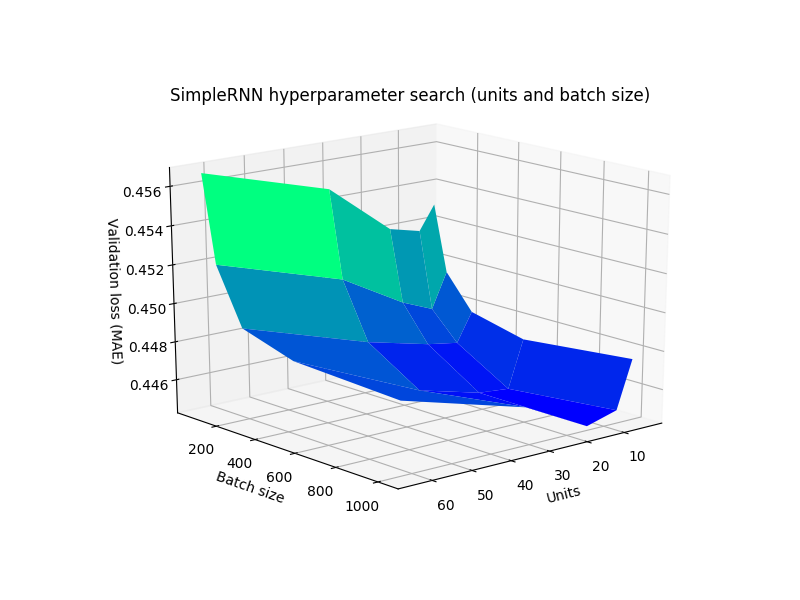

In [16]:
%matplotlib notebook
from mpl_toolkits.mplot3d import axes3d    
from mpl_toolkits import mplot3d

x = np.array([4,8,16,32,64])
y = np.array([64,128,256,512,1024])
X,Y = np.meshgrid(x, y)
z = np.array(complete_list)
print(X.shape)
print(Y.shape)
print(z.shape)
fig = pyplot.figure(figsize=(8, 6))
ax = pyplot.axes(projection='3d')
#ax.plot_surface(X, Y, z,cmap='viridis', edgecolor='none')
#ax.plot_wireframe(X, Y, z, color='g')
ax.set_xlabel('Units')
ax.set_ylabel('Batch size')
ax.set_zlabel('Validation loss (MAE)')
#ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, z, rstride=1, cstride=1,
                cmap='winter', edgecolor='none')
ax.set_title('SimpleRNN hyperparameter search (units and batch size)')
pyplot.show()

(125, 6)
(25, 3)


<IPython.core.display.Javascript object>


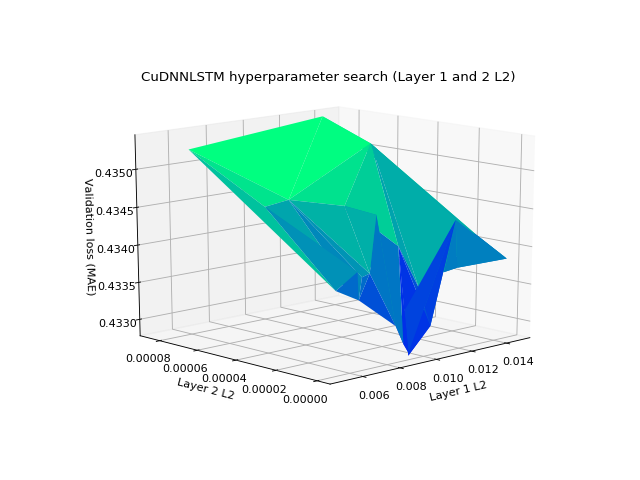

Text(0.5, 0.92, 'CuDNNLSTM hyperparameter search (Layer 1 and 2 L2)')

In [3]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D   
from mpl_toolkits import mplot3d

exp_record = [[16, 512, 0.00917022004702574, 2.6398141107060238e-08, 0, 0.4287186675336626], [16, 512, 0.00917022004702574, 2.6398141107060238e-08, 1, 0.43271883930100336], [16, 512, 0.00917022004702574, 2.6398141107060238e-08, 2, 0.4374961647722456], [16, 512, 0.00917022004702574, 2.6398141107060238e-08, 3, 0.43011495351791385], [16, 512, 0.00917022004702574, 2.6398141107060238e-08, 4, 0.435288817776574], [16, 512, 0.01220324493442158, 4.569021003882779e-05, 0, 0.43180439742406207], [16, 512, 0.01220324493442158, 4.569021003882779e-05, 1, 0.43352055949634977], [16, 512, 0.01220324493442158, 4.569021003882779e-05, 2, 0.4389006036652459], [16, 512, 0.01220324493442158, 4.569021003882779e-05, 3, 0.4331881734000312], [16, 512, 0.01220324493442158, 4.569021003882779e-05, 4, 0.4388246223926544], [16, 512, 0.005001143748173449, 6.978801842695444e-05, 0, 0.43319919906722176], [16, 512, 0.005001143748173449, 6.978801842695444e-05, 1, 0.4343590001000298], [16, 512, 0.005001143748173449, 6.978801842695444e-05, 2, 0.44002897297011484], [16, 512, 0.005001143748173449, 6.978801842695444e-05, 3, 0.43228069321314494], [16, 512, 0.005001143748173449, 6.978801842695444e-05, 4, 0.43675007560518053], [16, 512, 0.008023325726318397, 2.092561938722815e-05, 0, 0.4324277300039927], [16, 512, 0.008023325726318397, 2.092561938722815e-05, 1, 0.43376656500498456], [16, 512, 0.008023325726318397, 2.092561938722815e-05, 2, 0.43927649704615274], [16, 512, 0.008023325726318397, 2.092561938722815e-05, 3, 0.430875105910831], [16, 512, 0.008023325726318397, 2.092561938722815e-05, 4, 0.43720061548550926], [16, 512, 0.00646755890817113, 3.0720620704073386e-08, 0, 0.43127103808191086], [16, 512, 0.00646755890817113, 3.0720620704073386e-08, 1, 0.4328769329653846], [16, 512, 0.00646755890817113, 3.0720620704073386e-08, 2, 0.439251430273056], [16, 512, 0.00646755890817113, 3.0720620704073386e-08, 3, 0.4298371770117018], [16, 512, 0.00646755890817113, 3.0720620704073386e-08, 4, 0.4352047772672441], [16, 512, 0.005923385947687978, 4.0421522241984946e-05, 0, 0.43166753143734404], [16, 512, 0.005923385947687978, 4.0421522241984946e-05, 1, 0.43392700062857736], [16, 512, 0.005923385947687978, 4.0421522241984946e-05, 2, 0.4405441725254059], [16, 512, 0.005923385947687978, 4.0421522241984946e-05, 3, 0.4317633266184065], [16, 512, 0.005923385947687978, 4.0421522241984946e-05, 4, 0.43554095798068576], [16, 512, 0.006862602113776709, 2.068090311140799e-06, 0, 0.43078200205167133], [16, 512, 0.006862602113776709, 2.068090311140799e-06, 1, 0.43371075752046373], [16, 512, 0.006862602113776709, 2.068090311140799e-06, 2, 0.43847190939055547], [16, 512, 0.006862602113776709, 2.068090311140799e-06, 3, 0.4304747003184424], [16, 512, 0.006862602113776709, 2.068090311140799e-06, 4, 0.4363139715194702], [16, 512, 0.008455607270430477, 1.4738112911005874e-08, 0, 0.43125749066140917], [16, 512, 0.008455607270430477, 1.4738112911005874e-08, 1, 0.4309030913247002], [16, 512, 0.008455607270430477, 1.4738112911005874e-08, 2, 0.43784507483906215], [16, 512, 0.008455607270430477, 1.4738112911005874e-08, 3, 0.43032568158043755], [16, 512, 0.008455607270430477, 1.4738112911005874e-08, 4, 0.43594709759288364], [16, 512, 0.008967674742306699, 7.367817503575301e-07, 0, 0.43102584279908074], [16, 512, 0.008967674742306699, 7.367817503575301e-07, 1, 0.43192196361223856], [16, 512, 0.008967674742306699, 7.367817503575301e-07, 2, 0.4366313792069753], [16, 512, 0.008967674742306699, 7.367817503575301e-07, 3, 0.4304607890182071], [16, 512, 0.008967674742306699, 7.367817503575301e-07, 4, 0.43491160543759666], [16, 512, 0.010388167340033568, 1.708014464346949e-07, 0, 0.43134565265973407], [16, 512, 0.010388167340033568, 1.708014464346949e-07, 1, 0.4323497977521684], [16, 512, 0.010388167340033568, 1.708014464346949e-07, 2, 0.43732055507765877], [16, 512, 0.010388167340033568, 1.708014464346949e-07, 3, 0.4298187084992727], [16, 512, 0.010388167340033568, 1.708014464346949e-07, 4, 0.4349500568707784], [16, 512, 0.009191945144032949, 5.469372163776756e-06, 0, 0.4317758129437764], [16, 512, 0.009191945144032949, 5.469372163776756e-06, 1, 0.43660927110248143], [16, 512, 0.009191945144032949, 5.469372163776756e-06, 2, 0.4376011144849989], [16, 512, 0.009191945144032949, 5.469372163776756e-06, 3, 0.4309248645570543], [16, 512, 0.009191945144032949, 5.469372163776756e-06, 4, 0.4341977740128835], [16, 512, 0.011852195003967593, 1.7947182922216602e-07, 0, 0.4324268178939819], [16, 512, 0.011852195003967593, 1.7947182922216602e-07, 1, 0.4328363373809391], [16, 512, 0.011852195003967593, 1.7947182922216602e-07, 2, 0.4394181478023529], [16, 512, 0.011852195003967593, 1.7947182922216602e-07, 3, 0.4312513613700867], [16, 512, 0.011852195003967593, 1.7947182922216602e-07, 4, 0.43331657324896916], [16, 512, 0.007044522497315174, 4.586668073741429e-08, 0, 0.4297482074631585], [16, 512, 0.007044522497315174, 4.586668073741429e-08, 1, 0.4335115762816535], [16, 512, 0.007044522497315174, 4.586668073741429e-08, 2, 0.4391571858988868], [16, 512, 0.007044522497315174, 4.586668073741429e-08, 3, 0.4323153595129649], [16, 512, 0.007044522497315174, 4.586668073741429e-08, 4, 0.4352743199666341], [16, 512, 0.013781174363909451, 8.449808968512768e-05, 0, 0.43416945910453797], [16, 512, 0.013781174363909451, 8.449808968512768e-05, 1, 0.4350220257971022], [16, 512, 0.013781174363909451, 8.449808968512768e-05, 2, 0.43915742593341406], [16, 512, 0.013781174363909451, 8.449808968512768e-05, 3, 0.4324878521760305], [16, 512, 0.013781174363909451, 8.449808968512768e-05, 4, 0.4361426457299126], [16, 512, 0.005273875931979262, 9.986716932175409e-08, 0, 0.43084534674220615], [16, 512, 0.005273875931979262, 9.986716932175409e-08, 1, 0.4326345557636685], [16, 512, 0.005273875931979262, 9.986716932175409e-08, 2, 0.43894693178600735], [16, 512, 0.005273875931979262, 9.986716932175409e-08, 3, 0.4308009720908271], [16, 512, 0.005273875931979262, 9.986716932175409e-08, 4, 0.43609409215715195], [16, 512, 0.011704675101784022, 1.1080405249760348e-08, 0, 0.43278718778822156], [16, 512, 0.011704675101784022, 1.1080405249760348e-08, 1, 0.43396810274653963], [16, 512, 0.011704675101784022, 1.1080405249760348e-08, 2, 0.4377703359656864], [16, 512, 0.011704675101784022, 1.1080405249760348e-08, 3, 0.4325364049540626], [16, 512, 0.011704675101784022, 1.1080405249760348e-08, 4, 0.43533539803822835], [16, 512, 0.00917304802367127, 1.0170384743005824e-07, 0, 0.4306109459929996], [16, 512, 0.00917304802367127, 1.0170384743005824e-07, 1, 0.43226365433798897], [16, 512, 0.00917304802367127, 1.0170384743005824e-07, 2, 0.43741268685128953], [16, 512, 0.00917304802367127, 1.0170384743005824e-07, 3, 0.428850520239936], [16, 512, 0.00917304802367127, 1.0170384743005824e-07, 4, 0.4350117793083191], [16, 512, 0.010586898284457516, 7.554818440983928e-06, 0, 0.42995073241657683], [16, 512, 0.010586898284457516, 7.554818440983928e-06, 1, 0.43228144526481627], [16, 512, 0.010586898284457516, 7.554818440983928e-06, 2, 0.4381621419588725], [16, 512, 0.010586898284457516, 7.554818440983928e-06, 3, 0.43240712261199954], [16, 512, 0.010586898284457516, 7.554818440983928e-06, 4, 0.435217351992925], [16, 512, 0.006403869385952337, 6.964383632724288e-08, 0, 0.432404869556427], [16, 512, 0.006403869385952337, 6.964383632724288e-08, 1, 0.432695825126436], [16, 512, 0.006403869385952337, 6.964383632724288e-08, 2, 0.43799757668707107], [16, 512, 0.006403869385952337, 6.964383632724288e-08, 3, 0.43207603573799136], [16, 512, 0.006403869385952337, 6.964383632724288e-08, 4, 0.43508309276898705], [16, 512, 0.006981014890848788, 3.8645236879478225e-05, 0, 0.4326071910858154], [16, 512, 0.006981014890848788, 3.8645236879478225e-05, 1, 0.43373338209258183], [16, 512, 0.006981014890848788, 3.8645236879478225e-05, 2, 0.4396573219299316], [16, 512, 0.006981014890848788, 3.8645236879478225e-05, 3, 0.4303397390842438], [16, 512, 0.006981014890848788, 3.8645236879478225e-05, 4, 0.43737881032625836], [16, 512, 0.013007445686755367, 1.6159424704616844e-06, 0, 0.43132828585306804], [16, 512, 0.013007445686755367, 1.6159424704616844e-06, 1, 0.4332510350545247], [16, 512, 0.013007445686755367, 1.6159424704616844e-06, 2, 0.4383592239485847], [16, 512, 0.013007445686755367, 1.6159424704616844e-06, 3, 0.43196501151720684], [16, 512, 0.013007445686755367, 1.6159424704616844e-06, 4, 0.4362827949523926], [16, 512, 0.014682615757193974, 2.320694578236747e-08, 0, 0.43136107773251003], [16, 512, 0.014682615757193974, 2.320694578236747e-08, 1, 0.43168288379245334], [16, 512, 0.014682615757193974, 2.320694578236747e-08, 2, 0.4378225553830465], [16, 512, 0.014682615757193974, 2.320694578236747e-08, 3, 0.43232156459490456], [16, 512, 0.014682615757193974, 2.320694578236747e-08, 4, 0.43601553908983864], [16, 512, 0.008134241781592428, 6.6918069942206646e-06, 0, 0.4322342995007833], [16, 512, 0.008134241781592428, 6.6918069942206646e-06, 1, 0.43303437362776864], [16, 512, 0.008134241781592428, 6.6918069942206646e-06, 2, 0.4382890242735545], [16, 512, 0.008134241781592428, 6.6918069942206646e-06, 3, 0.43323737661043804], [16, 512, 0.008134241781592428, 6.6918069942206646e-06, 4, 0.4365159070226881], [16, 512, 0.01192322615669314, 7.061527352209339e-06, 0, 0.43184589563475717], [16, 512, 0.01192322615669314, 7.061527352209339e-06, 1, 0.43315982201364306], [16, 512, 0.01192322615669314, 7.061527352209339e-06, 2, 0.4372955301072862], [16, 512, 0.01192322615669314, 7.061527352209339e-06, 3, 0.4306580859820048], [16, 512, 0.01192322615669314, 7.061527352209339e-06, 4, 0.4357849923239814], [16, 512, 0.01376389152296038, 3.0191570976856964e-05, 0, 0.43269241799248587], [16, 512, 0.01376389152296038, 3.0191570976856964e-05, 1, 0.43263881561491224], [16, 512, 0.01376389152296038, 3.0191570976856964e-05, 2, 0.4388357769118415], [16, 512, 0.01376389152296038, 3.0191570976856964e-05, 3, 0.430456002579795], [16, 512, 0.01376389152296038, 3.0191570976856964e-05, 4, 0.4377838445239597]]

complete_v = np.array(exp_record)
print(complete_v.shape)
xyz = []
for i in range(25):
    fold_v = complete_v[(i*5):((i+1)*5), :]
    xyz.append([fold_v[0, 2], 
                fold_v[0, 3], 
                np.mean(fold_v[:, 5])])
xyz_v = np.array(xyz)
print(xyz_v.shape)

fig = pyplot.figure(figsize=(8, 6))
#ax = fig.add_subplot(111, projection='3d')
ax = pyplot.axes(projection='3d')
ax.set_xlabel('Layer 1 L2')
ax.set_ylabel('Layer 2 L2')
ax.set_zlabel('Validation loss (MAE)')
#ax = plt.axes(projection='3d')
#ax.plot_surface(X, Y, z, rstride=1, cstride=1,
#                cmap='winter', edgecolor='none')
ax.plot_trisurf(xyz_v[:, 0], xyz_v[:, 1], xyz_v[:, 2],
               cmap='winter', edgecolor='none')
ax.set_title('CuDNNLSTM hyperparameter search (Layer 1 and 2 L2)')